C:\Users\Cesar\AppData\Local\Temp\ipykernel_13748\2871240349.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed



===== Backtest Long & Short =====
Total operaciones: 21
Ganadoras: 6
Perdedoras: 15
Retorno total: -6.29%
Retorno promedio por operación: -0.30%
Máximo Drawdown: 22.01%
Sharpe Ratio: -0.13
Buy & Hold retorno: -65.30%


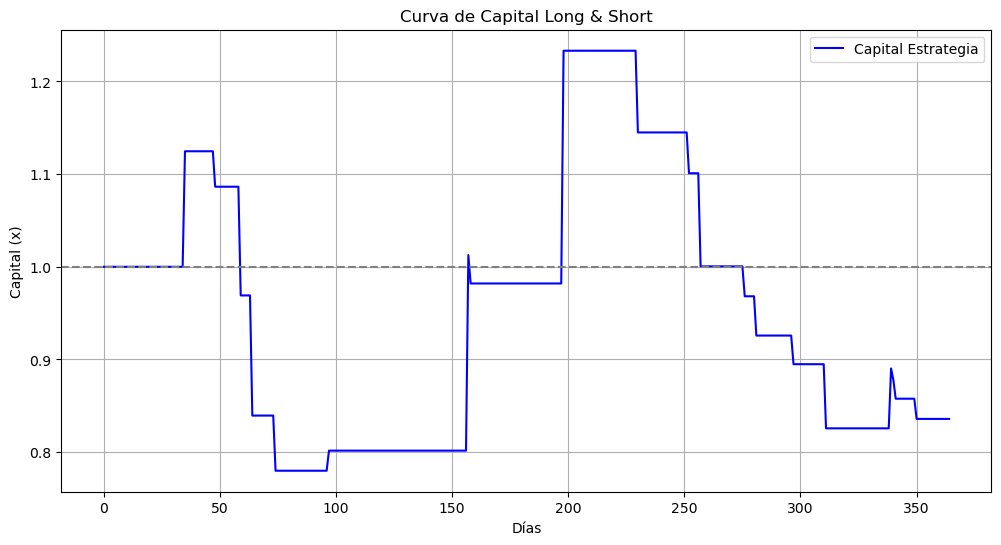

In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# DATA-CIERRE
data = yf.download(
    "BTC-USD",
    start="2022-01-01",
    end="2023-01-01",
    interval="1d"
)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

data = data[['Close_BTC-USD']].copy()
data.rename(columns={'Close_BTC-USD': 'close'}, inplace=True)
data = data.reset_index()

#EMAS
data['ema_fast'] = data['close'].ewm(span=5, adjust=False).mean()
data['ema_slow'] = data['close'].ewm(span=20, adjust=False).mean()

#SEÑALES
data['signal'] = 0
data.loc[data['ema_fast'] > data['ema_slow'], 'signal'] = 1
data.loc[data['ema_fast'] < data['ema_slow'], 'signal'] = -1

#BACKTESTCONDATOSPASADOS
position = None  
entry_price = 0
entry_date = None
trades = []
capital_curve = []
capital = 1.0 

for i, row in data.iterrows():
    signal = row['signal']
    price = row['close']

    if position is None:
        if signal == 1:
            position = 'long'
            entry_price = price
            entry_date = row['Date']
        elif signal == -1:
            position = 'short'
            entry_price = price
            entry_date = row['Date']
    else:
        
        if position == 'long' and signal == -1:
            exit_price = price
            exit_date = row['Date']
            ret = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'side': 'long',
                'return': ret
            })
            capital = capital * (1 + ret)
            position = 'short'
            entry_price = price
            entry_date = row['Date']
        elif position == 'short' and signal == 1:
            exit_price = price
            exit_date = row['Date']
            ret = (entry_price - exit_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'side': 'short',
                'return': ret
            })
            capital = capital * (1 + ret)
            position = 'long'
            entry_price = price
            entry_date = row['Date']

    #REGISTRODECAPITAL
    capital_curve.append(capital)

#CERRARPOSICIONESABIERTAS
if position == 'long':
    ret = (data['close'].iloc[-1] - entry_price) / entry_price
    trades.append({
        'entry_date': entry_date,
        'exit_date': data['Date'].iloc[-1],
        'entry_price': entry_price,
        'exit_price': data['close'].iloc[-1],
        'side': 'long',
        'return': ret
    })
    capital = capital * (1 + ret)

elif position == 'short':
    ret = (entry_price - data['close'].iloc[-1]) / entry_price
    trades.append({
        'entry_date': entry_date,
        'exit_date': data['Date'].iloc[-1],
        'entry_price': entry_price,
        'exit_price': data['close'].iloc[-1],
        'side': 'short',
        'return': ret
    })
    capital = capital * (1 + ret)

trades_df = pd.DataFrame(trades)

total_trades = len(trades_df)
wins = len(trades_df[trades_df['return'] > 0])
losses = len(trades_df[trades_df['return'] <= 0])
total_return = trades_df['return'].sum()
average_return = trades_df['return'].mean()
max_drawdown = (1 - np.min(capital_curve)) * 100

if trades_df['return'].std() != 0:
    sharpe_ratio = (trades_df['return'].mean() / trades_df['return'].std()) * np.sqrt(len(trades_df))
else:
    sharpe_ratio = np.nan

#RETORNOSISOLOMANTENIAMOS
price_start = data['close'].iloc[0]
price_end = data['close'].iloc[-1]
buy_hold_return = (price_end - price_start) / price_start * 100


print("\n===== Backtest Long & Short =====")
print(f"Total operaciones: {total_trades}")
print(f"Ganadoras: {wins}")
print(f"Perdedoras: {losses}")
print(f"Retorno total: {total_return*100:.2f}%")
print(f"Retorno promedio por operación: {average_return*100:.2f}%")
print(f"Máximo Drawdown: {max_drawdown:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Buy & Hold retorno: {buy_hold_return:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(capital_curve, label='Capital Estrategia', color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--')
plt.xlabel('Días')
plt.ylabel('Capital (x)')
plt.title('Curva de Capital Long & Short')
plt.legend()
plt.grid()
plt.show()
